In [1]:
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.ticker as ticker
import seaborn as sns

In [3]:
from sklearn.datasets import load_boston
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.inspection import permutation_importance
import multiprocessing

In [4]:
labels = pd.read_csv('../../csv/train_labels.csv')
labels.head()

,building_id,damage_grade
0,802906,3
1,28830,2
2,94947,3
3,590882,2
4,201944,3


In [5]:
values = pd.read_csv('../../csv/train_values.csv')
values.T

,0,1,2,3,4,5,6,7,8,9,...,260591,260592,260593,260594,260595,260596,260597,260598,260599,260600
building_id,802906,28830,94947,590882,201944,333020,728451,475515,441126,989500,...,560805,207683,226421,159555,827012,688636,669485,602512,151409,747594
geo_level_1_id,6,8,21,22,11,8,9,20,0,26,...,20,10,8,27,8,25,17,17,26,21
geo_level_2_id,487,900,363,418,131,558,475,323,757,886,...,368,1382,767,181,268,1335,715,51,39,9
geo_level_3_id,12198,2812,8973,10694,1488,6089,12066,12236,7219,994,...,5980,1903,8613,1537,4718,1621,2060,8163,1851,9101
count_floors_pre_eq,2,2,2,2,3,2,2,2,2,1,...,1,2,2,6,2,1,2,3,2,3
age,30,10,10,10,30,10,25,0,15,0,...,25,25,5,0,20,55,0,55,10,10
area_percentage,6,8,5,6,8,9,3,8,8,13,...,5,5,13,13,8,6,6,6,14,7
height_percentage,5,7,5,5,9,5,4,6,6,4,...,3,5,5,12,5,3,5,7,6,6
land_surface_condition,t,o,t,t,t,t,n,t,t,t,...,n,t,t,t,t,n,t,t,t,n
foundation_type,r,r,r,r,r,r,r,w,r,i,...,r,r,r,r,r,r,r,r,r,r


In [6]:
#Promedio de altura por piso
values['height_percentage_per_floor_pre_eq'] = values['height_percentage']/values['count_floors_pre_eq']
values['volume_percentage'] = values['area_percentage'] * values['height_percentage']

#Algunos promedios por localizacion
values['avg_age_for_geo_level_2_id'] = values.groupby('geo_level_2_id')['age'].transform('mean')

values['avg_area_percentage_for_geo_level_2_id'] = values.groupby('geo_level_2_id')['area_percentage'].transform('mean')

values['avg_height_percentage_for_geo_level_2_id'] = values.groupby('geo_level_2_id')['height_percentage'].transform('mean')

values['avg_count_floors_for_geo_level_2_id'] = values.groupby('geo_level_2_id')['count_floors_pre_eq'].transform('mean')

values['avg_age_for_geo_level_3_id'] = values.groupby('geo_level_3_id')['age'].transform('mean')

values['avg_area_percentage_for_geo_level_3_id'] = values.groupby('geo_level_3_id')['area_percentage'].transform('mean')

values['avg_height_percentage_for_geo_level_3_id'] = values.groupby('geo_level_3_id')['height_percentage'].transform('mean')

values['avg_count_floors_for_geo_level_3_id'] = values.groupby('geo_level_3_id')['count_floors_pre_eq'].transform('mean')

#Relacion material(los mas importantes segun el modelo 5)-antiguedad
values['20_yr_age_range'] = values['age'] // 20 * 20
values['20_yr_age_range'] = values['20_yr_age_range'].astype('str')
values['superstructure'] = ''
values['superstructure'] = np.where(values['has_superstructure_mud_mortar_stone'], values['superstructure'] + 'b', values['superstructure'])
values['superstructure'] = np.where(values['has_superstructure_cement_mortar_brick'], values['superstructure'] + 'e', values['superstructure'])
values['superstructure'] = np.where(values['has_superstructure_timber'], values['superstructure'] + 'f', values['superstructure'])
values['age_range_superstructure'] = values['20_yr_age_range'] + values['superstructure']
del values['20_yr_age_range'] 
del values['superstructure']

values

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,volume_percentage,avg_age_for_geo_level_2_id,avg_area_percentage_for_geo_level_2_id,avg_height_percentage_for_geo_level_2_id,avg_count_floors_for_geo_level_2_id,avg_age_for_geo_level_3_id,avg_area_percentage_for_geo_level_3_id,avg_height_percentage_for_geo_level_3_id,avg_count_floors_for_geo_level_3_id,age_range_superstructure
0,802906,6,487,12198,2,30,6,5,t,r,...,30,22.203704,7.488889,5.222222,1.951852,23.378378,7.432432,4.810811,1.918919,20b
1,28830,8,900,2812,2,10,8,7,o,r,...,56,17.311558,6.653266,5.638191,2.170854,13.750000,8.812500,7.250000,2.250000,0b
2,94947,21,363,8973,2,10,5,5,t,r,...,25,20.411932,8.586364,6.485795,2.707386,30.845588,9.808824,6.551471,2.647059,0b
3,590882,22,418,10694,2,10,6,5,t,r,...,30,18.390244,5.868293,3.736585,1.546341,17.258065,8.225806,4.870968,1.935484,0bf
4,201944,11,131,1488,3,30,8,9,t,r,...,72,36.917148,8.829480,6.096339,2.331407,30.204918,8.450820,6.983607,2.172131,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260596,688636,25,1335,1621,1,55,6,3,n,r,...,18,26.163793,7.198276,2.974138,1.000000,26.785714,10.785714,3.000000,1.000000,40b
260597,669485,17,715,2060,2,0,6,5,t,r,...,30,19.214559,8.195402,5.915709,2.666667,16.734694,8.122449,6.510204,2.755102,0b
260598,602512,17,51,8163,3,55,6,7,t,r,...,42,21.021021,5.375375,6.615616,2.768769,28.181818,6.136364,6.500000,2.772727,40b
260599,151409,26,39,1851,2,10,14,6,t,r,...,84,23.500495,15.659485,4.750371,1.526498,203.538136,15.190678,4.550847,1.525424,0e


In [7]:
values.isnull().values.any()

False

In [8]:
labels.isnull().values.any()

False

In [9]:
values.dtypes 

building_id                                   int64
geo_level_1_id                                int64
geo_level_2_id                                int64
geo_level_3_id                                int64
count_floors_pre_eq                           int64
age                                           int64
area_percentage                               int64
height_percentage                             int64
land_surface_condition                       object
foundation_type                              object
roof_type                                    object
ground_floor_type                            object
other_floor_type                             object
position                                     object
plan_configuration                           object
has_superstructure_adobe_mud                  int64
has_superstructure_mud_mortar_stone           int64
has_superstructure_stone_flag                 int64
has_superstructure_cement_mortar_stone        int64
has_superstr

In [10]:
values["building_id"].count() == values["building_id"].drop_duplicates().count()

True

In [11]:
values.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260601 entries, 0 to 260600
Data columns (total 50 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   building_id                               260601 non-null  int64  
 1   geo_level_1_id                            260601 non-null  int64  
 2   geo_level_2_id                            260601 non-null  int64  
 3   geo_level_3_id                            260601 non-null  int64  
 4   count_floors_pre_eq                       260601 non-null  int64  
 5   age                                       260601 non-null  int64  
 6   area_percentage                           260601 non-null  int64  
 7   height_percentage                         260601 non-null  int64  
 8   land_surface_condition                    260601 non-null  object 
 9   foundation_type                           260601 non-null  object 
 10  roof_type           

In [12]:
to_be_categorized = ["land_surface_condition", "foundation_type", "roof_type",\
                     "position", "ground_floor_type", "other_floor_type",\
                     "plan_configuration", "legal_ownership_status", "age_range_superstructure"]
for row in to_be_categorized:
    values[row] = values[row].astype("category")
values.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260601 entries, 0 to 260600
Data columns (total 50 columns):
 #   Column                                    Non-Null Count   Dtype   
---  ------                                    --------------   -----   
 0   building_id                               260601 non-null  int64   
 1   geo_level_1_id                            260601 non-null  int64   
 2   geo_level_2_id                            260601 non-null  int64   
 3   geo_level_3_id                            260601 non-null  int64   
 4   count_floors_pre_eq                       260601 non-null  int64   
 5   age                                       260601 non-null  int64   
 6   area_percentage                           260601 non-null  int64   
 7   height_percentage                         260601 non-null  int64   
 8   land_surface_condition                    260601 non-null  category
 9   foundation_type                           260601 non-null  category
 10  roof_typ

In [13]:
datatypes = dict(values.dtypes)
for row in values.columns:
    if datatypes[row] != "int64" and datatypes[row] != "int32" and \
       datatypes[row] != "int16" and datatypes[row] != "int8":
        continue
    if values[row].nlargest(1).item() > 32767 and values[row].nlargest(1).item() < 2**31:
        values[row] = values[row].astype(np.int32)
    elif values[row].nlargest(1).item() > 127:
        values[row] = values[row].astype(np.int16)
    else:
        values[row] = values[row].astype(np.int8)
values.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260601 entries, 0 to 260600
Data columns (total 50 columns):
 #   Column                                    Non-Null Count   Dtype   
---  ------                                    --------------   -----   
 0   building_id                               260601 non-null  int32   
 1   geo_level_1_id                            260601 non-null  int8    
 2   geo_level_2_id                            260601 non-null  int16   
 3   geo_level_3_id                            260601 non-null  int16   
 4   count_floors_pre_eq                       260601 non-null  int8    
 5   age                                       260601 non-null  int16   
 6   area_percentage                           260601 non-null  int8    
 7   height_percentage                         260601 non-null  int8    
 8   land_surface_condition                    260601 non-null  category
 9   foundation_type                           260601 non-null  category
 10  roof_typ

In [14]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260601 entries, 0 to 260600
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype
---  ------        --------------   -----
 0   building_id   260601 non-null  int64
 1   damage_grade  260601 non-null  int64
dtypes: int64(2)
memory usage: 4.0 MB


In [15]:
labels["building_id"] = labels["building_id"].astype(np.int32)
labels["damage_grade"] = labels["damage_grade"].astype(np.int8)
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260601 entries, 0 to 260600
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype
---  ------        --------------   -----
 0   building_id   260601 non-null  int32
 1   damage_grade  260601 non-null  int8 
dtypes: int32(1), int8(1)
memory usage: 1.2 MB


# Nuevo Modelo

In [16]:
important_values = values\
                .merge(labels, on="building_id")
important_values.drop(columns=["building_id"], inplace = True)
important_values["geo_level_1_id"] = important_values["geo_level_1_id"].astype("category")
important_values

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,...,avg_age_for_geo_level_2_id,avg_area_percentage_for_geo_level_2_id,avg_height_percentage_for_geo_level_2_id,avg_count_floors_for_geo_level_2_id,avg_age_for_geo_level_3_id,avg_area_percentage_for_geo_level_3_id,avg_height_percentage_for_geo_level_3_id,avg_count_floors_for_geo_level_3_id,age_range_superstructure,damage_grade
0,6,487,12198,2,30,6,5,t,r,n,...,22.203704,7.488889,5.222222,1.951852,23.378378,7.432432,4.810811,1.918919,20b,3
1,8,900,2812,2,10,8,7,o,r,n,...,17.311558,6.653266,5.638191,2.170854,13.750000,8.812500,7.250000,2.250000,0b,2
2,21,363,8973,2,10,5,5,t,r,n,...,20.411932,8.586364,6.485795,2.707386,30.845588,9.808824,6.551471,2.647059,0b,3
3,22,418,10694,2,10,6,5,t,r,n,...,18.390244,5.868293,3.736585,1.546341,17.258065,8.225806,4.870968,1.935484,0bf,2
4,11,131,1488,3,30,8,9,t,r,n,...,36.917148,8.829480,6.096339,2.331407,30.204918,8.450820,6.983607,2.172131,20,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260596,25,1335,1621,1,55,6,3,n,r,n,...,26.163793,7.198276,2.974138,1.000000,26.785714,10.785714,3.000000,1.000000,40b,2
260597,17,715,2060,2,0,6,5,t,r,n,...,19.214559,8.195402,5.915709,2.666667,16.734694,8.122449,6.510204,2.755102,0b,3
260598,17,51,8163,3,55,6,7,t,r,q,...,21.021021,5.375375,6.615616,2.768769,28.181818,6.136364,6.500000,2.772727,40b,3
260599,26,39,1851,2,10,14,6,t,r,x,...,23.500495,15.659485,4.750371,1.526498,203.538136,15.190678,4.550847,1.525424,0e,2


In [17]:
important_values.shape

(260601, 50)

In [18]:

X_train, X_test, y_train, y_test = train_test_split(important_values.drop(columns = 'damage_grade'),
                                                    important_values['damage_grade'], test_size = 0.2, random_state = 123)

In [19]:
#OneHotEncoding
def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1)
    res = res.drop([feature_to_encode], axis=1)
    return(res) 

features_to_encode = ["geo_level_1_id", "land_surface_condition", "foundation_type", "roof_type",\
                     "position", "ground_floor_type", "other_floor_type",\
                     "plan_configuration", "legal_ownership_status", "age_range_superstructure"]
for feature in features_to_encode:
    X_train = encode_and_bind(X_train, feature)
    X_test = encode_and_bind(X_test, feature)

In [20]:
X_train

,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,...,age_range_superstructure_80ef,age_range_superstructure_80f,age_range_superstructure_980,age_range_superstructure_980b,age_range_superstructure_980be,age_range_superstructure_980bef,age_range_superstructure_980bf,age_range_superstructure_980e,age_range_superstructure_980ef,age_range_superstructure_980f
103291,1274,4190,2,25,8,5,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
233923,1207,12014,1,10,9,3,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
166653,944,8232,3,40,7,6,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
150634,488,12448,2,0,7,5,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
82720,302,5339,1,10,5,3,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192476,217,10644,1,25,4,6,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
17730,600,4813,2,20,13,8,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
28030,463,4692,2,10,9,4,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
15725,600,157,2,50,5,8,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
# Utilizo los mejores parametros segun el GridSearch
rf_model = RandomForestClassifier(n_estimators = 150,
                                  max_depth = None,
                                  max_features = 50,
                                  min_samples_split = 15,
                                  min_samples_leaf = 1,
                                  criterion = "gini",
                                  verbose=True)
rf_model.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  3.3min finished


RandomForestClassifier(max_features=50, min_samples_split=15, n_estimators=150,
                       verbose=True)

In [22]:
rf_model.score(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   10.4s finished


0.8715416346891788

In [23]:
# Calculo el F1 score para mi training set.
y_preds = rf_model.predict(X_test)
f1_score(y_test, y_preds, average='micro')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    2.7s finished


0.7484507204389786

In [24]:
importances = pd.DataFrame({"column_name": X_train.columns, "importance": rf_model.feature_importances_})
less_important_values = importances.loc[importances['importance'] < 0.0002]
less_important_columns = less_important_values["column_name"].to_list()
less_important_columns

['has_secondary_use_institution',
 'has_secondary_use_school',
 'has_secondary_use_health_post',
 'has_secondary_use_gov_office',
 'has_secondary_use_use_police',
 'geo_level_1_id_29',
 'plan_configuration_a',
 'plan_configuration_c',
 'plan_configuration_f',
 'plan_configuration_m',
 'plan_configuration_n',
 'plan_configuration_o',
 'age_range_superstructure_0be',
 'age_range_superstructure_0bef',
 'age_range_superstructure_100',
 'age_range_superstructure_100be',
 'age_range_superstructure_100bef',
 'age_range_superstructure_100bf',
 'age_range_superstructure_100e',
 'age_range_superstructure_100ef',
 'age_range_superstructure_100f',
 'age_range_superstructure_120',
 'age_range_superstructure_120b',
 'age_range_superstructure_120be',
 'age_range_superstructure_120bf',
 'age_range_superstructure_120e',
 'age_range_superstructure_120ef',
 'age_range_superstructure_120f',
 'age_range_superstructure_140',
 'age_range_superstructure_140b',
 'age_range_superstructure_140bf',
 'age_range_su

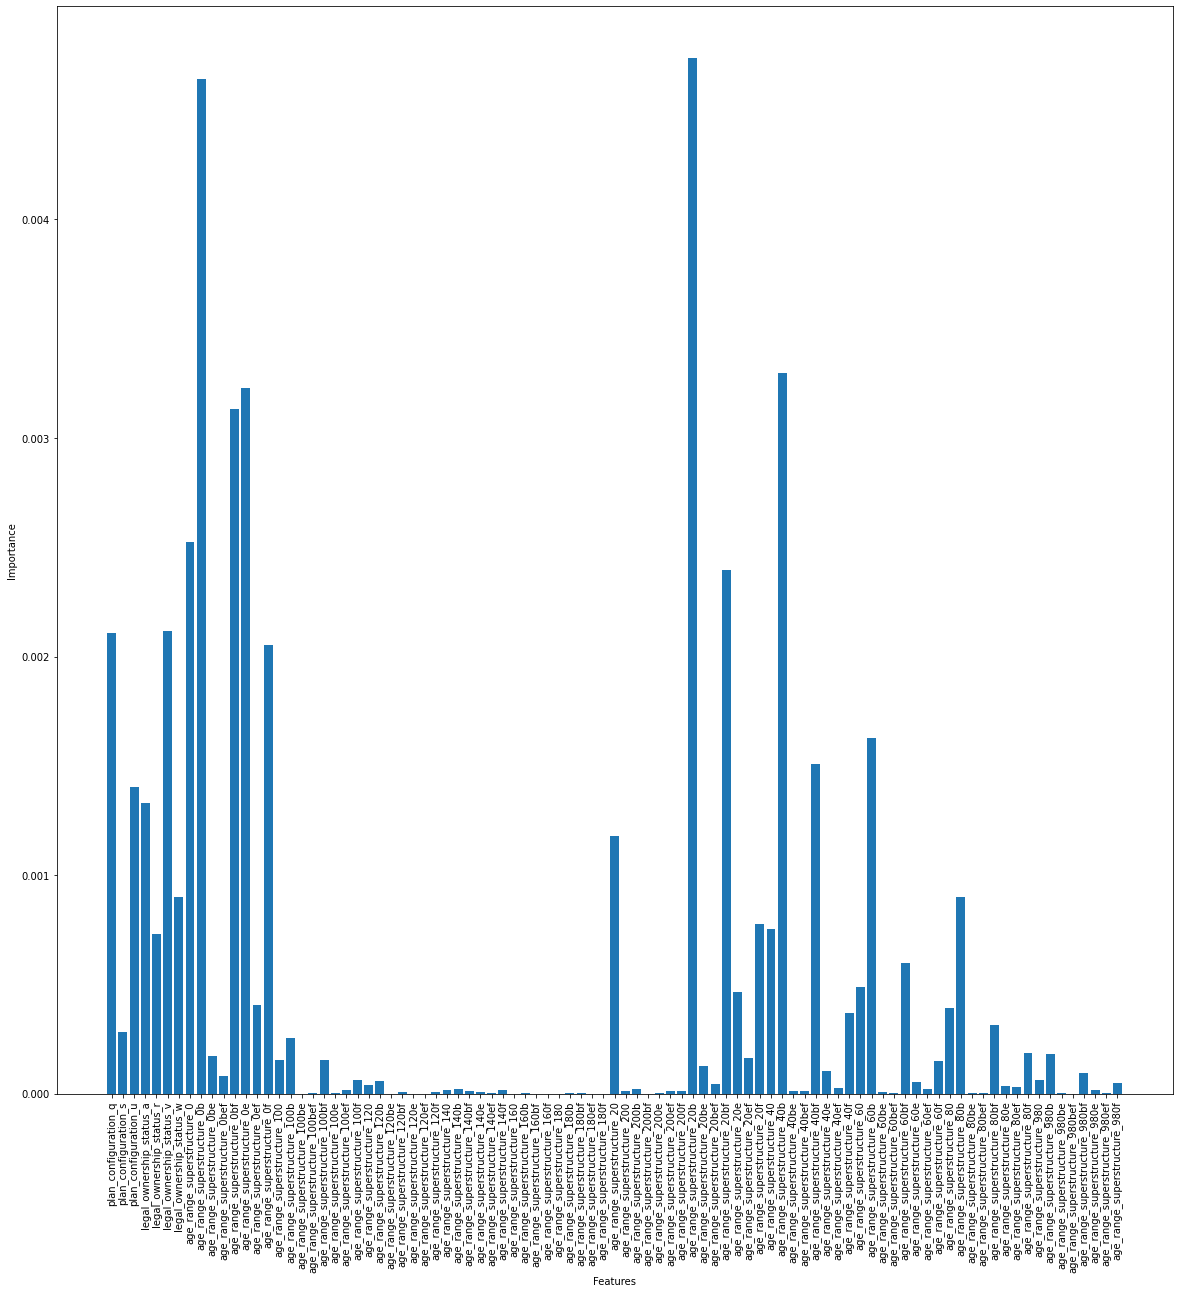

In [25]:
fig, ax = plt.subplots(figsize = (20,20))
plt.bar(X_train.columns[101:], rf_model.feature_importances_[101:])
plt.xlabel("Features")
plt.xticks(rotation = 90)
plt.ylabel("Importance")
plt.show()

In [26]:
X_train.drop(columns = less_important_columns, inplace = True)
X_test.drop(columns = less_important_columns, inplace = True)
X_train.shape

(208480, 118)

In [27]:
# # Busco los mejores tres parametros indicados abajo.
# n_estimators = [65, 100, 135]
# max_features = [0.2, 0.5, 0.8]
# max_depth = [None, 2, 5]
# min_samples_split = [5, 15, 25]
# # min_impurity_decrease = [0.0, 0.01, 0.025, 0.05, 0.1]
# # min_samples_leaf

# hyperF = {'n_estimators': n_estimators,
#           'max_features': max_features,  
#           'max_depth': max_depth, 
#           'min_samples_split': min_samples_split
# }

# gridF = GridSearchCV(estimator = RandomForestClassifier(random_state = 123),
#                      scoring = 'f1_micro',
#                      param_grid = hyperF,
#                      cv = 3,
#                      verbose = 1, 
#                      n_jobs = -1)

# bestF = gridF.fit(X_train, y_train)

In [28]:
# res = pd.DataFrame(bestF.cv_results_)
# res.loc[res['rank_test_score'] <= 10]

In [ ]:
rf_model_2 = RandomForestClassifier(n_estimators = 135,
                                  max_depth = None,
                                  max_features = 0.2,
                                  min_samples_split = 15,
                                  min_samples_leaf = 1,
                                  criterion = "gini",
                                  verbose=True)
rf_model_2.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


In [ ]:
rf_model_2.score(X_train, y_train)

In [ ]:
# Calculo el F1 score para mi training set.
y_preds = rf_model_2.predict(X_test)
f1_score(y_test, y_preds, average='micro')

In [ ]:
test_values = pd.read_csv('../../csv/test_values.csv', index_col = "building_id")
test_values

In [ ]:
test_values_subset = test_values
test_values_subset["geo_level_1_id"] = test_values_subset["geo_level_1_id"].astype("category")
test_values_subset

In [ ]:
#Promedio de altura por piso
test_values_subset['height_percentage_per_floor_pre_eq'] = test_values_subset['height_percentage']/test_values_subset['count_floors_pre_eq']
test_values_subset['volume_percentage'] = test_values_subset['area_percentage'] * test_values_subset['height_percentage']

#Algunos promedios por localizacion
test_values_subset['avg_age_for_geo_level_2_id'] = test_values_subset.groupby('geo_level_2_id')['age'].transform('mean')

test_values_subset['avg_area_percentage_for_geo_level_2_id'] = test_values_subset.groupby('geo_level_2_id')['area_percentage'].transform('mean')

test_values_subset['avg_height_percentage_for_geo_level_2_id'] = test_values_subset.groupby('geo_level_2_id')['height_percentage'].transform('mean')

test_values_subset['avg_count_floors_for_geo_level_2_id'] = test_values_subset.groupby('geo_level_2_id')['count_floors_pre_eq'].transform('mean')

test_values_subset['avg_age_for_geo_level_3_id'] = test_values_subset.groupby('geo_level_3_id')['age'].transform('mean')

test_values_subset['avg_area_percentage_for_geo_level_3_id'] = test_values_subset.groupby('geo_level_3_id')['area_percentage'].transform('mean')

test_values_subset['avg_height_percentage_for_geo_level_3_id'] = test_values_subset.groupby('geo_level_3_id')['height_percentage'].transform('mean')

test_values_subset['avg_count_floors_for_geo_level_3_id'] = test_values_subset.groupby('geo_level_3_id')['count_floors_pre_eq'].transform('mean')

#Relacion material(los mas importantes segun el modelo 5)-antiguedad
test_values_subset['20_yr_age_range'] = test_values_subset['age'] // 20 * 20
test_values_subset['20_yr_age_range'] = test_values_subset['20_yr_age_range'].astype('str')
test_values_subset['superstructure'] = ''
test_values_subset['superstructure'] = np.where(test_values_subset['has_superstructure_mud_mortar_stone'], test_values_subset['superstructure'] + 'b', test_values_subset['superstructure'])
test_values_subset['superstructure'] = np.where(test_values_subset['has_superstructure_cement_mortar_brick'], test_values_subset['superstructure'] + 'e', test_values_subset['superstructure'])
test_values_subset['superstructure'] = np.where(test_values_subset['has_superstructure_timber'], test_values_subset['superstructure'] + 'f', test_values_subset['superstructure'])
test_values_subset['age_range_superstructure'] = test_values_subset['20_yr_age_range'] + test_values_subset['superstructure']
del test_values_subset['20_yr_age_range'] 
del test_values_subset['superstructure']

test_values_subset

In [ ]:
def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1)
    res = res.drop([feature_to_encode], axis=1)
    return(res) 

features_to_encode = ["geo_level_1_id", "land_surface_condition", "foundation_type", "roof_type",\
                     "position", "ground_floor_type", "other_floor_type",\
                     "plan_configuration", "legal_ownership_status", "age_range_superstructure"]
for feature in features_to_encode:
    test_values_subset = encode_and_bind(test_values_subset, feature)
test_values_subset

In [ ]:
test_values_subset.columns
less_important_columns_new = filter(lambda c: c in test_values_subset.columns.to_list(), less_important_columns)
test_values_subset.drop(columns = less_important_columns_new, inplace = True)
test_values_subset.drop(columns = list(filter(lambda col: col not in X_train.columns.to_list() , test_values_subset.columns.to_list())), inplace = True)

In [ ]:
test_values_subset.shape

In [ ]:
# Genero las predicciones para los test.
preds = rf_model_2.predict(test_values_subset)

In [ ]:
submission_format = pd.read_csv('../../csv/submission_format.csv', index_col = "building_id")

In [ ]:
my_submission = pd.DataFrame(data=preds,
                             columns=submission_format.columns,
                             index=submission_format.index)

In [ ]:
my_submission.head()

In [ ]:
my_submission.to_csv('../../csv/predictions/jf-model-6-submission.csv')

In [ ]:
!head ../../csv/predictions/jf-model-6-submission.csv